<a href="https://colab.research.google.com/github/dogukartal/IBM_AI_Labs/blob/main/Gen%20AI%20Foundational%20Models%20for%20NLP%20%26%20Language%20Understanding/Building_and_Training_Language_Model_with_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building and Training a Simple Language Model with a Neural Network
---

## Setup


In [4]:
%%capture
import warnings
from tqdm import tqdm

warnings.simplefilter('ignore')
import time
from collections import OrderedDict

import re

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import nltk
nltk.download('punkt_tab')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import string
import time

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn
%capture

## Language modeling


In [5]:
song= """We are no strangers to love
You know the rules and so do I
A full commitments what Im thinking of
You wouldnt get this from any other guy
I just wanna tell you how Im feeling
Gotta make you understand
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Weve known each other for so long
Your hearts been aching but youre too shy to say it
Inside we both know whats been going on
We know the game and were gonna play it
And if you ask me how Im feeling
Dont tell me youre too blind to see
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Weve known each other for so long
Your hearts been aching but youre too shy to say it
Inside we both know whats been going on
We know the game and were gonna play it
I just wanna tell you how Im feeling
Gotta make you understand
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you"""

### Tokenization


In [66]:
from nltk.tokenize import word_tokenize

def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)
    return s

def preprocess(words):
    tokens = word_tokenize(words)
    tokens = [preprocess_string(w) for w in tokens]
    return [w.lower()  for w in tokens if len(w)!=0 or not(w in string.punctuation)]

tokens = preprocess(song)

tokens[0:10]

['we', 'are', 'no', 'strangers', 'to', 'love', 'you', 'know', 'the', 'rules']

In [54]:
# Create a frequency distribution of words
fdist = nltk.FreqDist(tokens)
fdist

FreqDist({'na': 40, 'gon': 38, 'you': 37, 'never': 36, 'and': 16, 'tell': 9, 'make': 8, 'say': 8, 'a': 7, 'give': 6, ...})

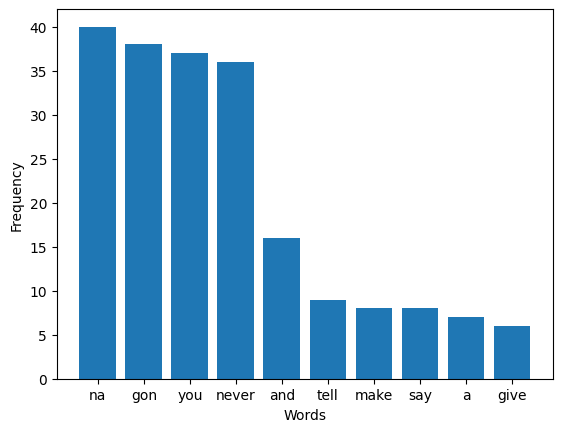

In [55]:
# Plot the words with the top ten frequencies
sorted_word_counts = sorted(fdist.items(), key=lambda item: item[1], reverse=True)
plt.bar([word for word, count in sorted_word_counts[:10]], [count for word, count in sorted_word_counts[:10]])
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

### Unigram model

An unigram model is a simple type of language model that considers each word in a sequence independently, without taking into account the previous words. In other words, it models the probability of each word occurring in the text, regardless of what came before it. Unigram models can be seen as a special case of n-gram models, where n is 1.


Find the probability of the word wish  i.w $P(strangers)$.


In [56]:
# Total count of each word
C = sum(fdist.values())
fdist['strangers']/C

0.0025974025974025974

In [22]:
vocabulary=set(tokens)

### Bigram model


**2-Gram models**: Bigram models use conditional probability. The probability of a word depends only on the previous word, i.e., the conditional probability $(W_{t}, W_{t-1})$ is used to predict the likelihood of word $(W_t)$ following word $W_{t-1}$ in a sequence. You can calculate the conditional probability for a bigram model using the following steps.


Perform the bigram word count for each bigram: $Count(W_{t-1}, W_{t})$

$Count(\text{I, like}) = 1$

$Count(\text{like, dogs}) = 1$

$Count(\text{dogs, and}) = 1$

$Count(\text{and, I}) = 1$

$Count(\text{I, kinda}) = 1$

$Count(\text{kinda, like}) = 1$

$Count(\text{like, cats}) = 1$


Now, let's calculate the conditional probability for each bigram in the form of $P(w_{t} | w_{t-1})$, where $w_{t-1}$ is the **context**, and the context size is one.

$P(\text{"like"} | \text{"I"}) = \frac{\text{Count}(\text{"I, like"})}{\text{Total count of "I"}} = \frac{1}{2} = 0.5$

$P(\text{"dogs"} | \text{"like"}) = \frac{\text{Count}(\text{"like, dogs"})}{\text{Total count of "like"}} = \frac{1}{2} = 0.5$

$:$

$P(\text{"like"} | \text{"kinda"}) = \frac{\text{Count}(\text{"kinda, like"})}{\text{Total count of "kinda"}} = \frac{1}{1} = 1$

$P(\text{"cats"} | \text{"like"}) = \frac{\text{Count}(\text{"like, cats"})}{\text{Total count of "like"}} = \frac{1}{2} = 0.5$

These probabilities represent the likelihood of encountering the second word in a bigram, given the presence of the first word.


This approach is, in fact, an approximation used to determine the most likely word $W_t$, given the words $W_{t-1}, W_{t-2}, \ldots, W_1$ in the sequence.

$P(W_t | W_{t-1}, W_{t-2}, \ldots, W_1) \approx P(W_t | W_{t-1})$

The conditional probability $P(W_t | W_{t-1})$ signifies the likelihood of encountering the word $W_t$, based on the context provided by the preceding word $W_{t-1}$. By employing this approximation, simplify the modeling process by assuming that the occurrence of the current word is mainly influenced by the most recent word in the sequence. In general, you have the capability to identify the most likely word.

$\hat{W_t} = \arg\max_{W_t} \left( P(W_t | W_{t-1}) \right)$


In [57]:
my_bigrams=list(nltk.bigrams(tokens)) # Convert the generator into a list
my_bigrams[0:10]

[('we', 'are'),
 ('are', 'no'),
 ('no', 'strangers'),
 ('strangers', 'to'),
 ('to', 'love'),
 ('love', 'you'),
 ('you', 'know'),
 ('know', 'the'),
 ('the', 'rules'),
 ('rules', 'and')]

In [25]:
freq_bigrams  = nltk.FreqDist(nltk.bigrams(tokens))
freq_bigrams

FreqDist({('gon', 'na'): 38, ('never', 'gon'): 36, ('you', 'never'): 9, ('na', 'tell'): 8, ('make', 'you'): 8, ('na', 'give'): 6, ('give', 'you'): 6, ('you', 'up'): 6, ('up', 'never'): 6, ('na', 'let'): 6, ...})

In [58]:
word = "you"
vocab_probabilities = {}
for next_word in vocabulary:
    vocab_probabilities[next_word] = freq_bigrams[(word, next_word)]/fdist[word] # Probability of next word is sampled
vocab_probabilities = sorted(vocab_probabilities.items(), key=lambda x:x[1], reverse=True)
vocab_probabilities[0:8]

[('never', 0.24324324324324326),
 ('up', 0.16216216216216217),
 ('down', 0.16216216216216217),
 ('cry', 0.16216216216216217),
 ('understand', 0.05405405405405406),
 ('weve', 0.05405405405405406),
 ('how', 0.05405405405405406),
 ('know', 0.02702702702702703)]

In [64]:
def make_predictions(my_words, freq_grams, normlize=1, vocabulary=vocabulary):
    """
    Generate predictions for the conditional probability of the next word given a sequence.

    Args:
        my_words (list): A list of words in the input sequence.
        freq_grams (dict): A dictionary containing frequency of n-grams.
        normlize (int): A normalization factor for calculating probabilities.
        vocabulary (list): A list of words in the vocabulary.

    Returns:
        list: A list of predicted words along with their probabilities, sorted in descending order.
    """

    vocab_probabilities = {}  # Initialize a dictionary to store predicted word probabilities

    context_size = len(list(freq_grams.keys())[0])  # Determine the context size from n-grams keys (number of grams)

    # Preprocess input words and take only the relevant context words
    my_tokens = preprocess(my_words)[0:context_size - 1]

    # Calculate probabilities for each word in the vocabulary given the context
    for next_word in vocabulary:
        temp = my_tokens.copy()
        temp.append(next_word)  # Add the next word to the context

        # Calculate the conditional probability using the frequency information
        if normlize!=0:
            vocab_probabilities[next_word] = freq_grams[tuple(temp)] / normlize
        else:
            vocab_probabilities[next_word] = freq_grams[tuple(temp)]
    # Sort the predicted words based on their probabilities in descending order
    vocab_probabilities = sorted(vocab_probabilities.items(), key=lambda x: x[1], reverse=True)

    return vocab_probabilities  # Return the sorted list of predicted words and their probabilities

In [71]:
my_words = "we"
vocab_probabilities = make_predictions(my_words, freq_bigrams, normlize=fdist['you'])
vocab_probabilities[0:10]

[('know', 0.05405405405405406),
 ('both', 0.05405405405405406),
 ('are', 0.02702702702702703),
 ('full', 0.0),
 ('dont', 0.0),
 ('of', 0.0),
 ('this', 0.0),
 ('on', 0.0),
 ('gon', 0.0),
 ('your', 0.0)]

In [72]:
my_song = ""
for w in tokens[0:100]:
  my_word = make_predictions(w, freq_bigrams)[0][0]
  my_song += " " + my_word
my_song

' know no strangers to say you never the game and hurt long i just lie commitments what im feeling of you never get this from any other for i just wan na tell a never im feeling got ta make you never never gon na tell you never never gon na tell you never never gon na tell around and hurt you never gon na tell you never never gon na tell goodbye never gon na tell a lie and hurt you never known each other for so long your hearts been aching but youre too shy to say goodbye'

In [73]:
my_song="i"
for i in range(100):
    my_word = make_predictions(my_word,freq_bigrams)[0][0]
    my_song += " " + my_word
my_song

'i never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never'

## Trigram model


In [74]:
freq_trigrams  = nltk.FreqDist(nltk.trigrams(tokens))
freq_trigrams

FreqDist({('never', 'gon', 'na'): 36, ('you', 'never', 'gon'): 9, ('gon', 'na', 'give'): 6, ('na', 'give', 'you'): 6, ('give', 'you', 'up'): 6, ('you', 'up', 'never'): 6, ('up', 'never', 'gon'): 6, ('gon', 'na', 'let'): 6, ('na', 'let', 'you'): 6, ('let', 'you', 'down'): 6, ...})

In [77]:
make_predictions("so do", freq_trigrams, normlize=freq_bigrams[('do','i')] )[0:10]

[('i', 1.0),
 ('full', 0.0),
 ('dont', 0.0),
 ('of', 0.0),
 ('this', 0.0),
 ('on', 0.0),
 ('gon', 0.0),
 ('your', 0.0),
 ('up', 0.0),
 ('know', 0.0)]

In [78]:
my_song = ""

w1 = tokens[0]
for w2 in tokens[0:100]:
    gram = w1+' '+w2
    my_word = make_predictions(gram,freq_trigrams )[0][0]
    my_song += " "+my_word
    w1 = w2
my_song

' full no strangers to love you know the game and so do i a full commitments what im thinking of you wouldnt get this from any other guy i just wan na tell a how im feeling got ta make you cry never gon na run you up never gon na run you down never gon na run around and desert you never gon na run you cry never gon na run goodbye never gon na run a lie and hurt you never known each other for so long your hearts been aching but youre too shy to say it'

## Feedforward Neural Networks (FNNs) for Language Models


In [ ]:
!pip install torch==2.3.0
!pip install torchtext==0.18.0

In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

In [6]:
tokenizer = get_tokenizer("basic_english")
tokens=tokenizer(song)

In [12]:
# Create a vocabulary from text tokens
tokenized_song = map(tokenizer, song.split())
# Add a special token "<unk>" (unknown token) to handle out-of-vocabulary words.
vocab = build_vocab_from_iterator(tokenized_song, specials=["<unk>"])
# Set the default index for the vocabulary to the index corresponding to the "<unk>" token. This ensures that any unknown tokens in the future will be mapped to this index.
vocab.set_default_index(vocab["<unk>"])

vocab(tokens[0:10])

[21, 58, 70, 74, 25, 69, 2, 20, 31, 72]

In [13]:
# Function converting raw text into indexes
text_pipeline = lambda x: vocab(tokenizer(x))
text_pipeline(song)[0:10]

[21, 58, 70, 74, 25, 69, 2, 20, 31, 72]

In [15]:
index_to_token = vocab.get_itos()
index_to_token[0:10]

['<unk>', 'gonna', 'you', 'never', 'and', 'tell', 'make', 'say', 'a', 'around']

### Embedding layers

An embedding layer serves to convert categorical variables, like words or discrete indexes representing tokens, into continuous vectors. This transformation facilitates training and enables the network to learn meaningful relationships among words.


In [16]:
embedding_dim = 20
vocab_size = len(vocab)
embeddings = nn.Embedding(vocab_size, embedding_dim)

In [17]:
for n in range(2):
    embedding = embeddings(torch.tensor(n))
    print("word",index_to_token[n])
    print("index",n)
    print( "embedding", embedding)
    print("embedding shape", embedding.shape)

word <unk>
index 0
embedding tensor([ 0.3263,  0.2503,  0.1513,  0.4641,  0.8397, -2.0608, -0.1737, -1.5348,
         0.4781,  1.2654, -0.4211, -1.4294,  0.0905, -0.4907, -2.3488, -0.3242,
         0.4932, -0.1520, -0.0814, -0.5046], grad_fn=<EmbeddingBackward0>)
embedding shape torch.Size([20])
word gonna
index 1
embedding tensor([ 1.7606, -0.3796, -0.5079,  0.0190, -0.5326,  1.9023, -1.6157,  0.4481,
        -0.7291, -2.1151, -0.6668,  1.1217,  3.5113, -0.0527, -0.5807, -1.4857,
         1.7282,  0.2416,  0.9626, -1.2503], grad_fn=<EmbeddingBackward0>)
embedding shape torch.Size([20])


### Generating N-grams


In [22]:
CONTEXT_SIZE = 2

ngrams = [
    (
        [tokens[i - j - 1] for j in range(CONTEXT_SIZE)],
        tokens[i]
    )
    for i in range(CONTEXT_SIZE, len(tokens))
]

context, target = ngrams[0]
print("Context:", context, "Target:", target)
print("Context index:", vocab(context), "Target index:", vocab([target]))

Context: ['are', 'we'] Target: no
Context index: [58, 21] Target index: [70]


In [23]:
linear = nn.Linear(embedding_dim * CONTEXT_SIZE, 128)

In [24]:
my_embeddings = embeddings(torch.tensor(vocab(context)))
my_embeddings.shape

torch.Size([2, 20])

In [31]:
# Reshape embeddings
my_embeddings=my_embeddings.reshape(1,-1)
my_embeddings.shape

torch.Size([1, 40])

In [33]:
my_embeddings

tensor([[ 0.3451,  0.2817, -1.3426, -1.1146, -0.6328, -0.1540,  0.5060,  3.0933,
          0.9645, -0.0908,  0.4226,  0.9317,  1.3197, -0.6738,  0.8227,  0.4680,
          0.9125,  0.5395,  0.5798,  1.1766,  0.3422,  0.1091, -0.4034, -0.6702,
         -0.5935, -0.1217,  0.3434,  1.3280,  0.9302, -0.3679,  1.8497, -1.7051,
         -0.4627, -0.6983,  0.0270,  1.4860, -1.6751,  0.0908, -0.4522,  0.1712]],
       grad_fn=<ViewBackward0>)

In [35]:
linear(my_embeddings)

tensor([[ 0.4807, -0.7002, -0.4272,  0.3593,  0.6310, -0.7430, -0.0151, -0.4137,
         -0.7282, -0.6639, -0.1793, -0.6024, -1.0646,  0.6582,  0.5733,  0.2233,
          0.0132,  0.3296,  0.2097, -0.5448, -0.1995, -0.3632, -0.1974, -0.1883,
          0.2109, -0.7799, -0.2593,  0.0396, -0.9362,  0.8616,  0.7563, -0.6056,
          0.7391, -0.1355, -0.2734, -0.6177, -0.9231,  0.5074, -0.2756,  0.1748,
         -0.0889, -0.7243, -0.8838, -0.1938,  0.4222, -0.6395,  0.7942,  0.6517,
         -0.3044,  0.6068,  0.3333, -0.1372,  0.0370,  0.7909, -1.2253,  0.1815,
         -0.4047, -0.7996,  0.2455,  0.1166, -0.4864,  0.9489, -0.1753,  0.4896,
         -0.1039,  0.2396, -0.3643,  0.8218,  0.2722,  0.0690,  0.8452,  0.6301,
          0.2692,  0.2062,  0.2709, -0.8346,  0.0152,  0.5511,  0.3264, -0.8002,
          0.3900,  0.2089, -0.0814, -0.4289,  0.2343,  0.1446, -0.0773, -1.1500,
         -0.4522, -0.4068,  0.4077,  0.8571, -0.4331, -1.4573, -0.4040, -0.5326,
         -0.0359,  0.3695, -

### Batch function


In [37]:
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CONTEXT_SIZE = 3
BATCH_SIZE = 10
EMBEDDING_DIM = 10

def collate_batch(batch):
    batch_size = len(batch)
    context, target = [], []
    for i in range(CONTEXT_SIZE, batch_size):
        target.append(vocab([batch[i]]))
        context.append(vocab([batch[i-j-1] for j in range(CONTEXT_SIZE)]))
    return torch.tensor(context).to(device), torch.tensor(target).to(device).reshape(-1)

In [38]:
Padding = BATCH_SIZE - len(tokens) % BATCH_SIZE
tokens_pad = tokens + tokens[0:Padding]

In [50]:
dataloader = DataLoader(
     tokens_pad, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch
)

### Multi-class neural network


In [51]:
class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.context_size=context_size
        self.embedding_dim=embedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs)
        embeds=torch.reshape( embeds, (-1,self.context_size * self.embedding_dim))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        return out

model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE).to(device)

In [52]:
context, target = next(iter(dataloader))
out = model(context)
out.shape

torch.Size([7, 79])

In [48]:
# Find the index with the highest probability
predicted_index = torch.argmax(out,1)
predicted_index

tensor([43, 67, 49, 14, 40, 44, 42])

In [49]:
[index_to_token[i.item()] for i in  predicted_index]

['inside', 'guy', 'play', 'goodbye', 'going', 'just', 'hearts']

In [53]:
def write_song(model,number_of_words=100):
    my_song=""
    for i in range(number_of_words):
        with torch.no_grad():
            context=torch.tensor(vocab([tokens[i-j-1] for j in range(CONTEXT_SIZE)])).to(device)
            word_inx=torch.argmax(model(context))
            my_song+=" "+index_to_token[word_inx.detach().item()]

    return my_song

In [54]:
write_song(model)

' just inside just from going strangers long whats tell strangers weve inside just whats strangers strangers give just get inside going get each love just how from are love love long from love going im love long how im love around whats just long from love wanna just going but just love are to long see weve are around inside going long around inside just to going this me around from this thinking cry love just inside just how strangers love long to tell inside strangers love strangers if from get strangers how how are get going this if feeling'

## Training


In [56]:
def train(dataloader, model, number_of_epochs=100, show=10):
    """
    Args:
        dataloader (DataLoader): DataLoader containing training data.
        model (nn.Module): Neural network model to be trained.
        number_of_epochs (int, optional): Number of epochs for training. Default is 100.
        show (int, optional): Interval for displaying progress. Default is 10.

    Returns:
        list: List containing loss values for each epoch.
    """

    MY_LOSS = []  # List to store loss values for each epoch

    # Iterate over the specified number of epochs
    for epoch in tqdm(range(number_of_epochs)):
        total_loss = 0  # Initialize total loss for the current epoch
        my_song = ""    # Initialize a string to store the generated song

        # Iterate over batches in the dataloader
        for context, target in dataloader:
            model.zero_grad()          # Zero the gradients to avoid accumulation
            predicted = model(context)  # Forward pass through the model to get predictions
            loss = criterion(predicted, target.reshape(-1))  # Calculate the loss
            total_loss += loss.item()   # Accumulate the loss

            loss.backward()    # Backpropagation to compute gradients
            optimizer.step()   # Update model parameters using the optimizer

        # Display progress and generate song at specified intervals
        if epoch % show == 0:
            my_song += write_song(model)  # Generate song using the model

            print("Generated Song:")
            print("\n")
            print(my_song)

        MY_LOSS.append(total_loss/len(dataloader))  # Append the total loss for the epoch to MY_LOSS list

    return MY_LOSS  # Return the list of  mean loss values for each epoch

my_loss_list=[]

# Define the context size for the n-gram model
CONTEXT_SIZE = 2

# Create an instance of the NGramLanguageModeler class with specified parameters
model_2 = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE).to(device)

# Define the criterion Cross Entropy Loss
criterion = torch.nn.CrossEntropyLoss()

# Define the optimizer as stochastic gradient descent (SGD)
optimizer = optim.SGD(model_2.parameters(), lr=0.01)

# Set up a learning rate scheduler using StepLR to adjust the learning rate during training
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1.0, gamma=0.1)

# Train the model
my_loss=train(dataloader,model_2)

# Save the model
save_path = '2gram.pth'
torch.save(model_2.state_dict(), save_path)
my_loss_list.append(my_loss)

  4%|▍         | 4/100 [00:00<00:05, 17.81it/s]

Generated Song:


 gonna lie never thinking were you see you you and you you lie lie whats gonna gonna you were desert know aching gonna give i gonna gonna gonna gonna lie gonna and never you gonna you lie gonna i a aching you you wouldnt we aching were gonna wouldnt both gonna you you wouldnt gonna lie a lie gonna you wouldnt a aching give gonna wouldnt never shy lie wouldnt gonna gonna gonna lie shy gonna gonna from were a you a lie you never gonna give youre were you gonna gonna and lie you you <unk> lie aching gonna


 14%|█▍        | 14/100 [00:00<00:03, 23.55it/s]

Generated Song:


 never never never never never gonna never never gonna you never you you gonna gonna you you you gonna you gonna never never never never gonna gonna never you you gonna you you you never never never you gonna you never never gonna you you never never gonna you you never never gonna you gonna gonna you you never gonna you you never never gonna you never never gonna you you you never you you never gonna you never you gonna you you you you you never never gonna gonna never gonna never gonna never gonna you you you never


 24%|██▍       | 24/100 [00:01<00:02, 26.93it/s]

Generated Song:


 never never never never and gonna never never never and never you you gonna gonna you and you gonna you you never never never never you gonna never you you gonna you you you up never never you you you never never gonna tell you up never gonna tell you never never gonna tell you and desert you never gonna tell you never never gonna tell you never gonna tell you you and hurt you never never you and and you you you you you you never never never gonna never gonna never never never gonna you you you never


 33%|███▎      | 33/100 [00:01<00:03, 21.07it/s]

Generated Song:


 never never never never to love never never never and never hurt you gonna gonna you and you gonna to you never never never never you gonna and you and gonna you tell you up never never you you you cry never gonna tell you up never gonna tell you down never gonna tell around and desert you never gonna tell you cry never gonna tell you never gonna tell you lie and hurt you never never you other and you you and you you a never never never gonna never gonna never never never gonna and whats you never


 45%|████▌     | 45/100 [00:02<00:02, 21.18it/s]

Generated Song:


 never never never strangers to love never never gonna and never hurt you gonna gonna give and you gonna to around never never never never you gonna and you and gonna you tell you up im feeling a make you cry never gonna tell you up never gonna tell you down never gonna tell around and desert you never gonna tell you cry never gonna tell goodbye never gonna tell you lie and hurt you never never each other and you you and you you aching but youre never gonna make gonna never never never gonna know whats been never


 54%|█████▍    | 54/100 [00:02<00:02, 21.53it/s]

Generated Song:


 never never know strangers to love never never gonna game and hurt you gonna gonna you and been gonna to around never never never never you gonna and you i gonna you tell you up im feeling gotta make you cry never gonna tell you up never gonna tell you down never gonna tell around and desert you never gonna tell you cry never gonna tell goodbye never gonna tell a lie and hurt you never never each other and you you and you been aching but youre too shy make gonna never never we both know whats been going


 63%|██████▎   | 63/100 [00:02<00:01, 21.27it/s]

Generated Song:


 never never know strangers to love to never the game and hurt you i gonna you and been im to around never we never never you gonna and you i gonna you tell you how im feeling gotta make you cry never gonna tell you up never gonna tell you down never gonna tell around and desert you never gonna tell you cry never gonna tell goodbye never gonna tell a lie and hurt you never known each other for i you and you been aching but youre too shy make gonna never never we both know whats been going


 74%|███████▍  | 74/100 [00:03<00:01, 19.72it/s]

Generated Song:


 never never no strangers to love to never the game and hurt you i gonna you and been im to around never we never never you gonna and you i gonna you tell you how im feeling gotta make you cry never gonna tell you up never gonna tell you down never gonna tell around and desert you never gonna tell you cry never gonna tell goodbye never gonna tell a lie and hurt you never known each other for i you and hearts been aching but youre too shy make gonna never inside we both know whats been going


 85%|████████▌ | 85/100 [00:04<00:00, 19.05it/s]

Generated Song:


 never never no strangers to love you never the game and hurt you i gonna full and been im to around inside wouldnt never never you gonna and you i gonna you tell you how im feeling gotta make you cry never gonna tell you up never gonna tell you down never gonna tell around and desert you never gonna tell you cry never gonna tell goodbye never gonna tell a lie and hurt you never known each other for so you and hearts been aching but youre too shy make gonna never inside we both know whats been going


 93%|█████████▎| 93/100 [00:04<00:00, 17.95it/s]

Generated Song:


 never never no strangers to love you never the game and hurt you i gonna full and been im to around inside wouldnt never no you gonna and guy i gonna you tell you how im feeling gotta make you cry never gonna tell you up never gonna tell you down never gonna tell around and desert you never gonna tell you cry never gonna tell goodbye never gonna tell a lie and hurt you never known each other for so you and hearts been aching but youre too shy to gonna never inside we both know whats been going


100%|██████████| 100/100 [00:04<00:00, 20.89it/s]


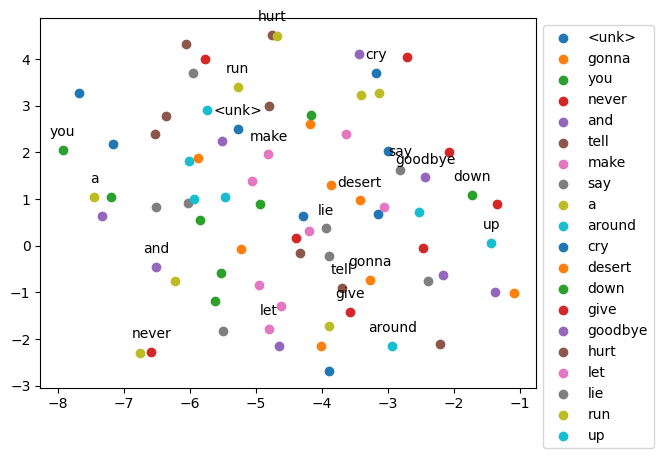

In [57]:
# Plots word embeddings from the created model, reduces their dimensionality to 2D using t-SNE
X = model_2.embeddings.weight.cpu().detach().numpy()
tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(X)

labels = []

for j in range(len(X_2d)):
    if j < 20:
        plt.scatter(X_2d[j, 0], X_2d[j, 1], label=index_to_token[j])
        labels.append(index_to_token[j])
        # Add words as annotations
        plt.annotate(index_to_token[j],
                     (X_2d[j, 0], X_2d[j, 1]),
                     textcoords="offset points",
                     xytext=(0, 10),
                     ha='center')
    else:
        plt.scatter(X_2d[j, 0], X_2d[j, 1])

plt.legend(labels, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [58]:
CONTEXT_SIZE=4
model_4 = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE).to(device)
optimizer = optim.SGD(model_4.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
my_loss=train(dataloader,model_4 )

save_path = '4gram.pth'
torch.save(model_4.state_dict(), save_path)

my_loss_list.append(my_loss)

  7%|▋         | 7/100 [00:00<00:03, 29.65it/s]

Generated Song:


 you for you play love you your you you and so you you play you you you you never going make ask cry you play you and you been understand inside a you weve guy inside feeling you you play you you you you you youre you see you inside you going you and you youre you you you weve and weve weve weve and you never weve love and you youre you youre you you going you you you and inside make you been inside you and going you your you run you you love around you been inside


 15%|█▌        | 15/100 [00:00<00:02, 30.25it/s]

Generated Song:


 never gonna gonna gonna gonna you you never never gonna you you gonna you gonna gonna gonna you never you never gonna never gonna gonna gonna you you you gonna gonna gonna you you you never gonna you gonna you you never gonna you you never never gonna you you never never gonna gonna you and you you never gonna gonna you never never gonna you you never gonna tell you you never gonna you never gonna gonna you you gonna never never never gonna you never gonna never gonna gonna you you you never gonna gonna gonna you gonna


 23%|██▎       | 23/100 [00:00<00:02, 26.83it/s]

Generated Song:


 never gonna never gonna gonna love you you never gonna and you gonna you gonna make gonna and never going never never never never gonna gonna you around guy gonna you gonna make and how never feeling around make you you never gonna tell you up never gonna let you never never gonna tell around and desert you never gonna make you down never gonna say you never gonna tell you lie and gonna you never gonna gonna you you gonna never never never make you never youre never gonna gonna gonna you you never gonna know whats been you


 35%|███▌      | 35/100 [00:01<00:02, 29.11it/s]

Generated Song:


 never known never know to love you never never gonna and a gonna been gonna make gonna and you going never down never never make gonna you other guy i a gonna make and how im feeling gotta make you you never gonna let you up never gonna let you down never gonna tell around and desert you never gonna make you down never gonna say goodbye never gonna tell a lie and hurt you never known gonna other for gonna never know never been aching but youre too shy to tell make you never both know whats been going


 46%|████▌     | 46/100 [00:01<00:01, 29.85it/s]

Generated Song:


 never known both know to love you never never gonna and were gonna play gonna make gonna what you going never down never never to gonna tell other guy i im gonna make and how im feeling gotta make you you never gonna let you up never gonna let you down never gonna run around and desert you never gonna make you down never gonna say goodbye never gonna tell a lie and hurt you never known each other for gonna how shy never been aching but youre too shy to tell gotta you never both know whats been going


 54%|█████▍    | 54/100 [00:01<00:01, 26.99it/s]

Generated Song:


 never known both know to love you know never gonna and were gonna play gonna full commitments what you thinking never i never never this gonna tell other guy i im a make other how im feeling gotta make you you never gonna run you up never gonna let you down never gonna run around and desert you never gonna make you down never gonna say goodbye never gonna tell a lie and hurt you never known each other for so how shy never been aching but youre too shy to play it you never both know whats been going


 63%|██████▎   | 63/100 [00:02<00:01, 23.67it/s]

Generated Song:


 never are no strangers to love you know the gonna and were gonna play a full commitments what im thinking never i never never this from any other guy i im a make other how im feeling gotta make you you never gonna run you up never gonna let you down never gonna run around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt you never known each other for so im shy never been aching but youre too shy to see it goodbye never both know whats been going


 72%|███████▏  | 72/100 [00:02<00:01, 19.69it/s]

Generated Song:


 never are no strangers to love you know the gonna and were gonna play a full commitments what im thinking never i never never this from any other guy i im a make other how im feeling gotta make you you never gonna run you up never gonna let you down never gonna run around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt you never known each other for so im shy never been aching but youre too shy to see it goodbye we both know whats been going


 84%|████████▍ | 84/100 [00:03<00:00, 20.24it/s]

Generated Song:


 never are no strangers to love you know the rules and were gonna play a full commitments what im thinking never i never never this from any other guy i im a make other how im feeling gotta make you you never gonna run you up never gonna let you down never gonna run around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt you never known each other for so im shy never been aching but youre too shy to see it goodbye we both know whats been going


 93%|█████████▎| 93/100 [00:03<00:00, 21.37it/s]

Generated Song:


 never are no strangers to love you know the rules and were gonna play a full commitments what im thinking never i never never this from any other guy i im a make other how im feeling gotta make you you never gonna run you up never gonna let you down never gonna run around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt you never known each other for so im shy never been aching but youre too shy to see it goodbye we both know whats been going


100%|██████████| 100/100 [00:04<00:00, 24.29it/s]


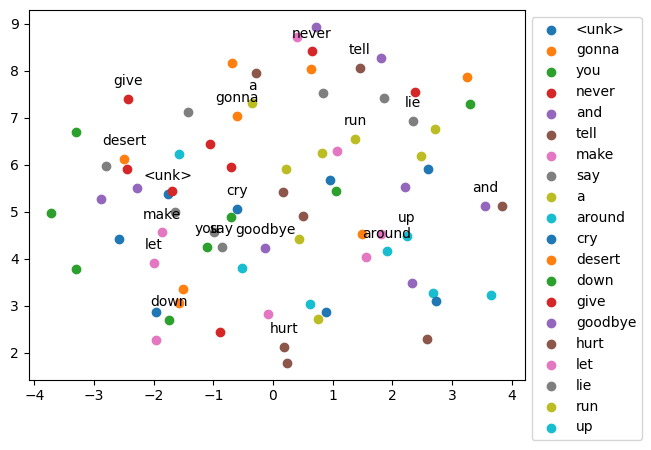

In [59]:
X = model_4.embeddings.weight.cpu().detach().numpy()
tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(X)

labels = []

for j in range(len(X_2d)):
    if j < 20:
        plt.scatter(X_2d[j, 0], X_2d[j, 1], label=index_to_token[j])
        labels.append(index_to_token[j])
        # Add words as annotations
        plt.annotate(index_to_token[j],
                     (X_2d[j, 0], X_2d[j, 1]),
                     textcoords="offset points",
                     xytext=(0, 10),
                     ha='center')
    else:
        plt.scatter(X_2d[j, 0], X_2d[j, 1])

plt.legend(labels, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [60]:
CONTEXT_SIZE=8
model_8 = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE).to(device)
optimizer = optim.SGD(model_8.parameters(), lr=0.01)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
my_loss=train(dataloader,model_8)

save_path = '8gram.pth'
torch.save(model_8.state_dict(), save_path)

my_loss_list.append(my_loss)

  4%|▍         | 4/100 [00:00<00:04, 20.98it/s]

Generated Song:


 you you make full game me no im what been just the just gonna im you guy thinking you too im you you the so you you hurt guy game lie know game know you im im gonna guy you me you hurt what guy just you make im you you me too know make let gonna im you been im you you you too know too lie guy desert you hurt im were you you you hurt were you long what you me im shy know shy weve shy guy you cry im desert you lie you shy you


 15%|█▌        | 15/100 [00:00<00:02, 29.38it/s]

Generated Song:


 never you make you gonna you you gonna the you make you gonna gonna gonna you you never you you gonna you you never gonna you you you gonna i you you tell never gonna make gonna you make you gonna gonna gonna you around never gonna gonna let you down never gonna you around you gonna tell never gonna make you you never gonna say around you gonna tell a never gonna tell you never you gonna you for you gonna you gonna tell gonna gonna make too shy gonna you never gonna you you you never gonna going


 26%|██▌       | 26/100 [00:00<00:02, 28.91it/s]

Generated Song:


 never never make you gonna love you tell the rules make you gonna gonna tell you never never im thinking let you you never gonna you around you guy i you say tell a gonna make gonna you make you never tell let you around never gonna gonna let you down never gonna run around and gonna tell never gonna make you down never gonna say around and gonna tell a lie gonna hurt you never you gonna other for so gonna you gonna never gonna gonna make too shy to you never gonna you you you never been going


 37%|███▋      | 37/100 [00:01<00:02, 29.44it/s]

Generated Song:


 never never make you gonna love you play the rules make you gonna gonna tell you never never im thinking let you you never gonna you around you guy i thinking say tell a gonna make thinking you make you never tell hurt you around and gonna gonna let you down never gonna run around and gonna tell never gonna make you down never gonna say around and gonna tell a lie gonna hurt you never you gonna other for so gonna i gonna never gonna gonna make too shy to you never gonna you you you never been going


 45%|████▌     | 45/100 [00:01<00:01, 30.86it/s]

Generated Song:


 never never make you gonna love you play the rules make you gonna gonna tell you never never im thinking let you you never gonna you around you guy i thinking say tell a gonna make thinking you make you never tell hurt run around and gonna gonna let you down never gonna run around and gonna tell never gonna make you down never gonna say around and gonna tell a lie gonna hurt you never you make other for so gonna i gonna never gonna gonna make too shy to you never gonna you you you never been going


 53%|█████▎    | 53/100 [00:01<00:01, 30.49it/s]

Generated Song:


 never never make you gonna love you play the rules make you gonna gonna tell you never never im thinking let you you never gonna you around you guy i thinking say tell a gonna make thinking you make you guy tell hurt run around and gonna gonna let you down never gonna run around and gonna tell never gonna make you down never gonna say around and gonna tell a lie gonna hurt you never you make other for so gonna i gonna never gonna gonna make too shy to you never gonna you you you never been going


 64%|██████▍   | 64/100 [00:02<00:01, 28.46it/s]

Generated Song:


 never never make you gonna love you play the rules make you gonna gonna tell you never never im thinking let you you never gonna you around you guy i thinking say tell a gonna make thinking you make you guy tell hurt run around and gonna gonna let you down never gonna run around and gonna tell never gonna make you down never gonna say around and gonna tell a lie gonna hurt you never you make other for so gonna i gonna never gonna gonna make too shy to you never gonna you you you never been going


 76%|███████▌  | 76/100 [00:02<00:00, 30.87it/s]

Generated Song:


 never never make you gonna love you play the rules been you gonna gonna tell you never never im thinking let you you never gonna you around you guy i thinking say tell a gonna make thinking you make you guy tell hurt run around and gonna gonna let you down never gonna run around and gonna tell never gonna make you down never gonna say around and gonna tell a lie gonna hurt you never you make other for so gonna i gonna never gonna gonna make too shy to you never gonna you you you never been going


 84%|████████▍ | 84/100 [00:02<00:00, 29.79it/s]

Generated Song:


 never never make you gonna love you play the rules been you gonna gonna tell you never never im thinking let you you never gonna you around you guy i thinking say tell a gonna make thinking you make you guy tell hurt run around and gonna gonna let you down never gonna run around and gonna tell never gonna make you up never gonna say around and gonna tell a lie gonna hurt you never you make other for so gonna i gonna never gonna gonna make too shy to you never gonna you you you never been going


 95%|█████████▌| 95/100 [00:03<00:00, 29.24it/s]

Generated Song:


 never never make you gonna love you play the rules been you gonna gonna tell you never never im thinking let you down never gonna you around you guy i thinking say tell a gonna make thinking you make you guy tell hurt run around and gonna gonna let you down never gonna run around and gonna tell never gonna make you up never gonna say around and gonna tell a lie gonna hurt you never you make other for so gonna i gonna never gonna gonna make too shy to you never gonna you you you never been going


100%|██████████| 100/100 [00:03<00:00, 29.19it/s]


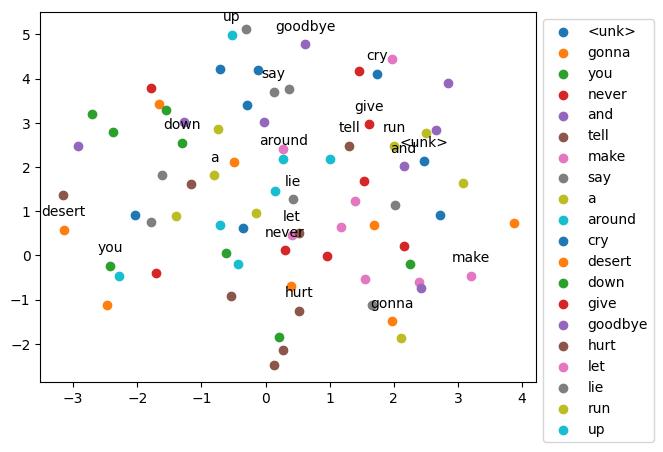

In [61]:
X = model_8.embeddings.weight.cpu().detach().numpy()
tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(X)

labels = []

for j in range(len(X_2d)):
    if j < 20:
        plt.scatter(X_2d[j, 0], X_2d[j, 1], label=index_to_token[j])
        labels.append(index_to_token[j])
        # Add words as annotations
        plt.annotate(index_to_token[j],
                     (X_2d[j, 0], X_2d[j, 1]),
                     textcoords="offset points",
                     xytext=(0, 10),
                     ha='center')
    else:
        plt.scatter(X_2d[j, 0], X_2d[j, 1])

plt.legend(labels, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

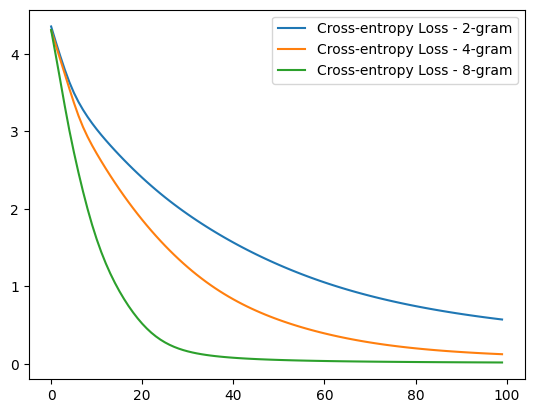

In [62]:
for (my_loss, model_name)in zip(my_loss_list,["2-gram","4-gram","8-gram"]):
    plt.plot(my_loss,label="Cross-entropy Loss - {}".format(model_name))
    plt.legend()

## Perplexity
Perplexity is a measurement used to evaluate the effectiveness of language models or probability models.

$$\text{Cross-Entropy Loss} = -\sum_{i=1}^{N} y_i \ln(p_i)$$

$$\text{Perplexity} = e^{\frac{1}{N} \text{Cross-Entropy Loss}}$$


A lower perplexity value indicates that the model is more confident and accurate in predicting the data. Conversely, a higher perplexity suggests that the model is less certain and less accurate in its predictions.

Perplexity can be seen as an estimate of the average number of choices the model has for the next word or event in a sequence. A lower perplexity means that the model is more certain about the next word, while a higher perplexity means that there are more possible choices.


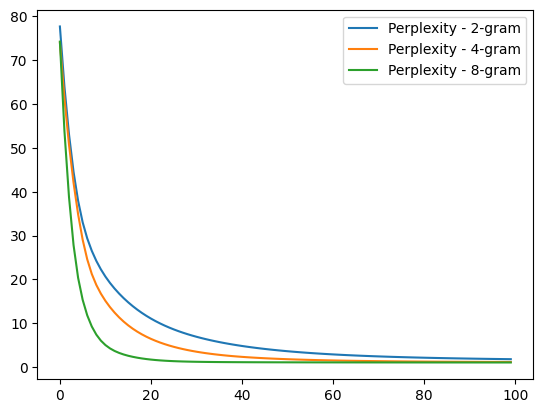

In [63]:
for (my_loss, model_name)in zip(my_loss_list,["2-gram","4-gram","8-gram"]):
    # Calculate perplexity using the loss
    perplexity = np.exp(my_loss)
    plt.plot(perplexity,label="Perplexity - {}".format(model_name))
    plt.legend()